In [1]:
import cma
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.optimize import minimize, dual_annealing
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import time
from tqdm.notebook import tqdm
import warnings

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

PLOT_PATH = 'plots'
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

D_BENCHMARK = 2
ROSENBROCK_BOUNDS = [(-2, 2)]*D_BENCHMARK
RASTRIGIN_BOUNDS = [(-5.12, 5.12)]*D_BENCHMARK
ACKLEY_BOUNDS = [(-32.768, 32.768)]*D_BENCHMARK
ROSENBROCK_MIN = np.array([1.0] * D_BENCHMARK)
RASTRIGIN_MIN = np.array([0.0] * D_BENCHMARK)
ACKLEY_MIN = np.array([0.0] * D_BENCHMARK)


MAX_ITER_BENCHMARK = 300
MAX_FEVALS_BENCHMARK = 5000

MNIST_SUBSET_SIZE = 1000
SVM_CV_FOLDS = 3
MAX_ITER_SVM = 50
MAX_FEVALS_SVM = 100

SVM_BOUNDS_LOG = [(-3, 3), (-4, 1)]

In [3]:
def rosenbrock(x):
    """Rosenbrock function (vector input)."""
    x = np.asarray(x)
    return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2, axis=0)

def rastrigin(x):
    """Rastrigin function (vector input)."""
    x = np.asarray(x)
    d = len(x)
    return 10 * d + np.sum(x**2 - 10 * np.cos(2 * np.pi * x), axis=0)

def ackley(x):
    """Ackley function (vector input)."""
    x = np.asarray(x)
    d = len(x)
    sum_sq = np.sum(x**2)
    sum_cos = np.sum(np.cos(2 * np.pi * x))
    term1 = -20.0 * np.exp(-0.2 * np.sqrt(sum_sq / d))
    term2 = -np.exp(sum_cos / d)
    return term1 + term2 + 20.0 + np.e

In [4]:
trajectories = {}
fevals_count = {}
optimization_log = {}

def store_minimize_traj_callback(optimizer_name):
    trajectories[optimizer_name] = []

    def callback(xk, *args):
        current_point = None
        if isinstance(xk, np.ndarray):
            current_point = xk
        elif hasattr(xk, 'x') and isinstance(xk.x, np.ndarray):
            current_point = xk.x

        if current_point is not None:
            if not trajectories[optimizer_name] or not np.allclose(trajectories[optimizer_name][-1], current_point):
                trajectories[optimizer_name].append(np.copy(current_point))

    return callback

def store_sa_traj_callback(optimizer_name):
    trajectories[optimizer_name] = []
    def callback(x, f, context):
        if not trajectories[optimizer_name] or not np.allclose(trajectories[optimizer_name][-1], x):
            trajectories[optimizer_name].append(np.copy(x))
    return callback


def objective_wrapper(func, optimizer_name):
    fevals_count[optimizer_name] = 0
    def wrapper(x, *args):
        fevals_count[optimizer_name] += 1
        return func(x)
    return wrapper


def run_optimizer(optimizer_func, obj_func, start_point, method_name, options={}, bounds=None): # Removed callback arg
    print(f"Running {method_name}...")
    wrapped_obj = objective_wrapper(obj_func, method_name)

    trajectories[method_name] = [np.copy(start_point)]

    t0 = time.time()
    if method_name == "Nelder-Mead":
        cb = store_minimize_traj_callback(method_name)
        trajectories[method_name] = [np.copy(start_point)]
        res = optimizer_func(wrapped_obj, start_point, method='Nelder-Mead', options=options, callback=cb)
        final_x = res.x
        final_f = res.fun
        fevals = res.nfev
        if not np.allclose(trajectories[method_name][-1], final_x):
            trajectories[method_name].append(final_x)

    elif method_name == "Simulated Annealing":
        sa_cb_instance = store_sa_traj_callback(method_name)
        trajectories[method_name] = [np.copy(start_point)]
        res = optimizer_func(wrapped_obj, bounds=bounds, x0=start_point, maxiter=options.get('maxiter'), maxfun=options.get('maxfev'), callback=sa_cb_instance, seed=RANDOM_STATE)
        final_x = res.x
        final_f = res.fun
        fevals = fevals_count.get(method_name, res.nfev if hasattr(res, 'nfev') else -1)
        if not np.allclose(trajectories[method_name][-1], final_x):
            trajectories[method_name].append(final_x)


    elif method_name == "CMA-ES":
        sigma0 = (bounds[0][1] - bounds[0][0]) / 4
        cma_options = {
            'bounds': [[b[0] for b in bounds], [b[1] for b in bounds]],
            'maxfevals': options.get('maxfev'),
            'verb_disp': 0, 'verb_log': 0,
            'seed': RANDOM_STATE
        }
        es = cma.CMAEvolutionStrategy(start_point, sigma0, inopts=cma_options)

        fevals_count[method_name] = 0
        trajectories[method_name] = [np.copy(start_point)]

        while not es.stop():
             solutions = es.ask()
             fitness_values = [obj_func(x) for x in solutions]
             fevals_count[method_name] += len(solutions)
             es.tell(solutions, fitness_values)
             current_best_x = es.result.xbest
             if not trajectories[method_name] or not np.allclose(trajectories[method_name][-1], current_best_x):
                   trajectories[method_name].append(np.copy(current_best_x))

        final_x = es.result.xbest
        final_f = es.result.fbest
        fevals = fevals_count[method_name]

    else:
        raise ValueError("Unknown optimizer method")

    t1 = time.time()
    duration = t1 - t0
    print(f"{method_name}: Done in {duration:.2f}s, FEvals={fevals}, f(x)={final_f:.4f}")

    if method_name not in optimization_log:
        optimization_log[method_name] = {}

    optimization_log[method_name].update({'time': duration, 'fevals': fevals, 'final_x': final_x, 'final_f': final_f})
    return final_x, final_f

--- Task 1: Benchmarking on Test Functions ---

===== Optimizing Rosenbrock function (D=2) =====
Start point: [-0.50183952  1.80285723]
Running Nelder-Mead...
Nelder-Mead: Done in 0.00s, FEvals=180, f(x)=0.0000
Running Simulated Annealing...
Simulated Annealing: Done in 0.03s, FEvals=1351, f(x)=0.0000
Running CMA-ES...
CMA-ES: Done in 0.05s, FEvals=732, f(x)=0.0000


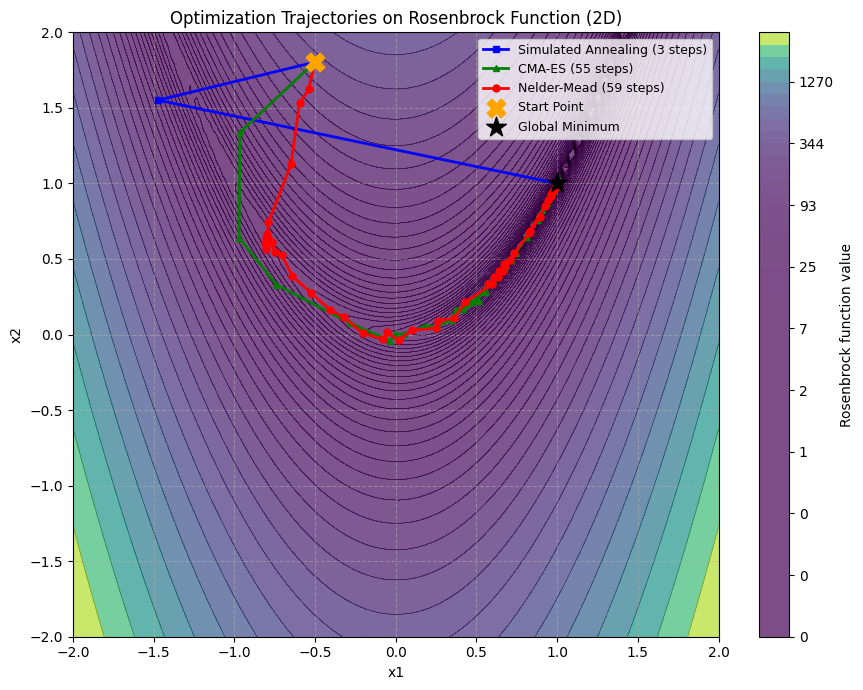


===== Optimizing Rastrigin function (D=2) =====
Start point: [ 3.07272672 -3.0306751 ]
Running Nelder-Mead...
Nelder-Mead: Done in 0.00s, FEvals=53, f(x)=17.9092
Running Simulated Annealing...
Simulated Annealing: Done in 0.02s, FEvals=1264, f(x)=0.0000
Running CMA-ES...
CMA-ES: Done in 0.04s, FEvals=612, f(x)=0.9950


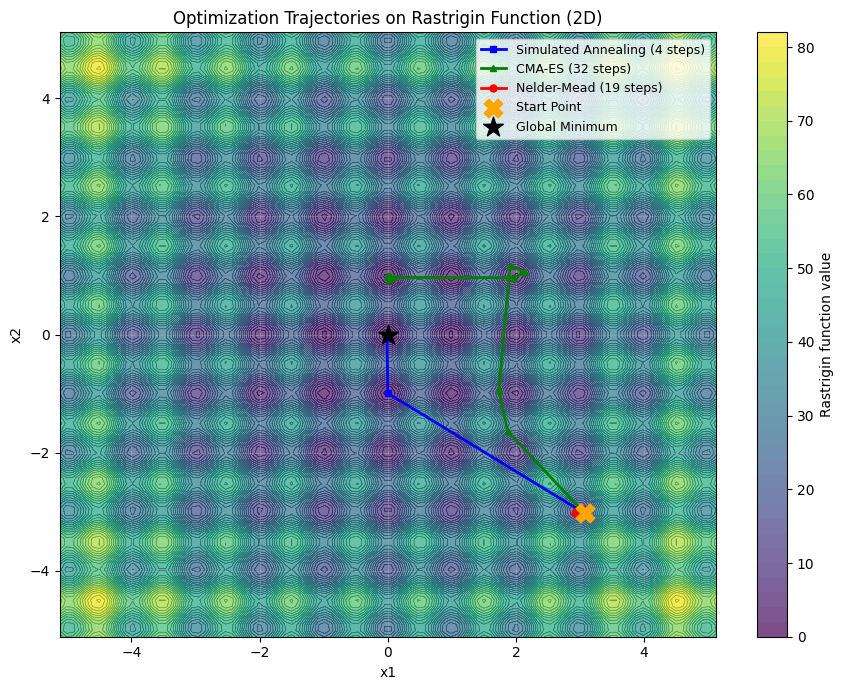


===== Optimizing Ackley function (D=2) =====
Start point: [-18.56374046 -26.49525089]
Running Nelder-Mead...
Nelder-Mead: Done in 0.00s, FEvals=81, f(x)=19.8606
Running Simulated Annealing...
Simulated Annealing: Done in 0.03s, FEvals=1408, f(x)=0.0000
Running CMA-ES...
CMA-ES: Done in 0.08s, FEvals=732, f(x)=0.0000


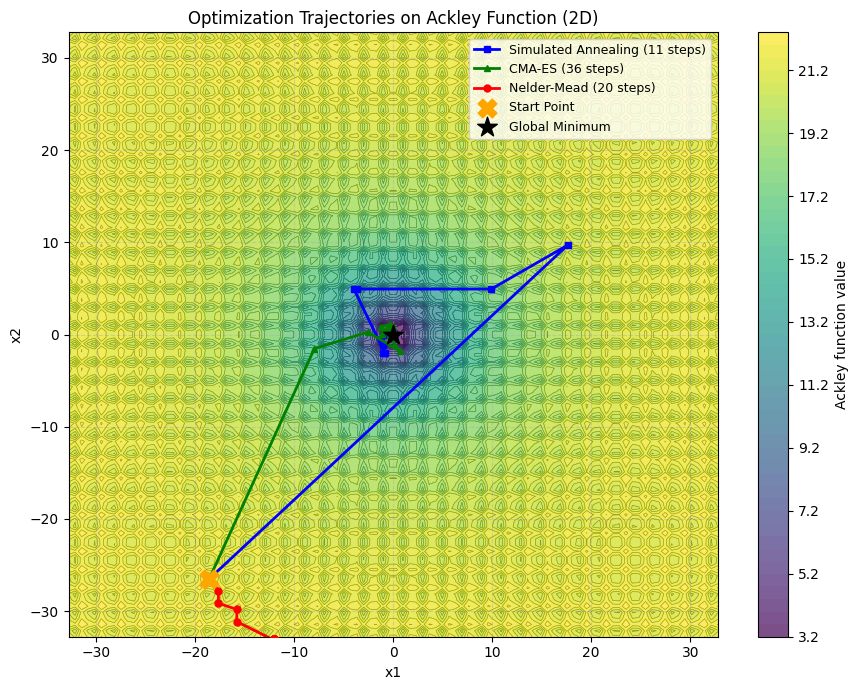


===== Benchmark Performance Summary =====
                                fevals       final_f      time
Function   Optimizer                                          
Rosenbrock Nelder-Mead             180  5.484937e-10  0.003014
           Simulated Annealing    1351  9.729037e-12  0.026972
           CMA-ES                  732  9.093765e-17  0.049240
Rastrigin  Nelder-Mead              53  1.790920e+01  0.001493
           Simulated Annealing    1264  7.105427e-15  0.021167
           CMA-ES                  612  9.949591e-01  0.044097
Ackley     Nelder-Mead              81  1.986056e+01  0.001497
           Simulated Annealing    1408  1.232890e-08  0.026995
           CMA-ES                  732  1.215072e-11  0.076287


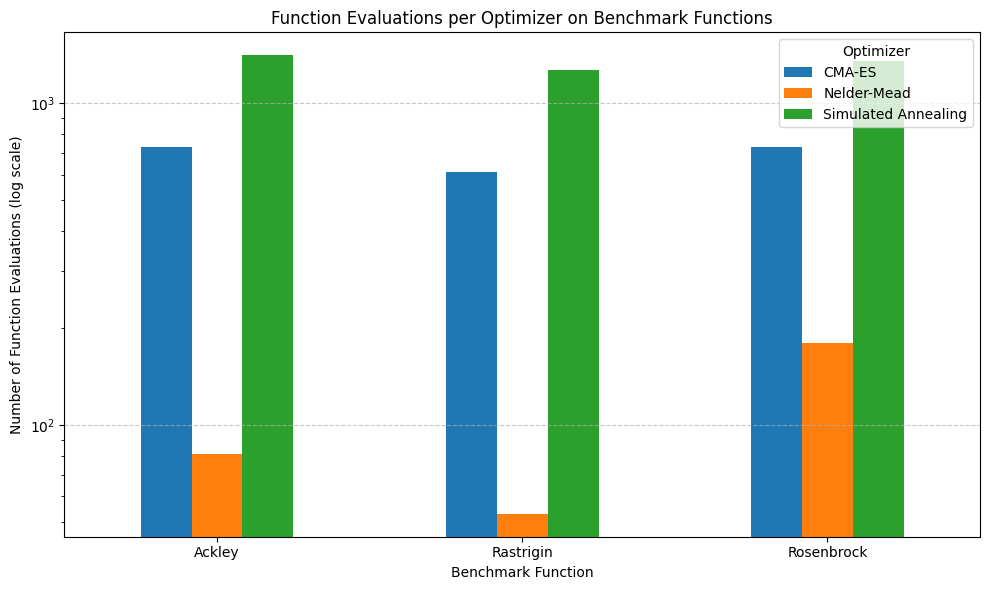

In [5]:
print("--- Task 1: Benchmarking on Test Functions ---")

benchmark_functions = {
    "Rosenbrock": {'func': rosenbrock, 'bounds': ROSENBROCK_BOUNDS, 'min': ROSENBROCK_MIN},
    "Rastrigin": {'func': rastrigin, 'bounds': RASTRIGIN_BOUNDS, 'min': RASTRIGIN_MIN},
    "Ackley": {'func': ackley, 'bounds': ACKLEY_BOUNDS, 'min': ACKLEY_MIN}
}

results_benchmark = {}

for name, bench in benchmark_functions.items():
    print(f"\n===== Optimizing {name} function (D={D_BENCHMARK}) =====")
    func = bench['func']
    bounds = bench['bounds']
    min_val_known = func(bench['min'])
    optimization_log = {}

    opts = {'maxiter': MAX_ITER_BENCHMARK, 'maxfev': MAX_FEVALS_BENCHMARK}

    start_point = np.random.uniform(bounds[0][0], bounds[0][1], size=D_BENCHMARK)
    print(f"Start point: {start_point}")

    run_optimizer(minimize, func, start_point, "Nelder-Mead", options=opts)
    run_optimizer(dual_annealing, func, start_point, "Simulated Annealing", options=opts, bounds=bounds)
    run_optimizer(cma.CMAEvolutionStrategy, func, start_point, "CMA-ES", options=opts, bounds=bounds)
    results_benchmark[name] = optimization_log.copy()

    if D_BENCHMARK == 2:
        plt.figure(figsize=(9, 7))
        x_range = np.linspace(bounds[0][0], bounds[0][1], 100)
        y_range = np.linspace(bounds[1][0], bounds[1][1], 100)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

        levels = np.logspace(np.log10(max(1e-2, Z.min())), np.log10(Z.max()), 50) if name == "Rosenbrock" else 50
        contour = plt.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.7)
        plt.colorbar(contour, label=f'{name} function value')
        plt.contour(X, Y, Z, levels=contour.levels, colors='black', alpha=0.3, linewidths=0.5)

        markers = {'Nelder-Mead': 'o-', 'Simulated Annealing': 's-', 'CMA-ES': '^-'}
        colors = {'Nelder-Mead': 'red', 'Simulated Annealing': 'blue', 'CMA-ES': 'green'}

        base_linewidth = 2.0
        base_markersize = 5

        for opt_name in ["Simulated Annealing", "CMA-ES", "Nelder-Mead"]:
            traj_list = trajectories.get(opt_name, [])
            if not traj_list: continue

            current_zorder = 5
            if opt_name == 'Nelder-Mead':
                current_zorder = 10

            if len(traj_list) > 1:
                traj_arr = np.array(traj_list)
                step = max(1, len(traj_arr) // 100)

                plt.plot(traj_arr[::step, 0], traj_arr[::step, 1], markers[opt_name], label=f'{opt_name} ({len(traj_list)} steps)', color=colors[opt_name], markersize=base_markersize, linewidth=base_linewidth, zorder=current_zorder)
            elif len(traj_list) == 1:
                 final_x = optimization_log.get(opt_name, {}).get('final_x', None)
                 if final_x is not None and not np.allclose(traj_list[0], final_x):
                      plt.plot([traj_list[0][0], final_x[0]], [traj_list[0][1], final_x[1]], markers[opt_name], label=f'{opt_name} (2 steps)', color=colors[opt_name], markersize=base_markersize+1, linewidth=base_linewidth, zorder=current_zorder)

        plt.scatter(start_point[0], start_point[1], marker='X', color='orange', s=180, label='Start Point', zorder=15)
        plt.scatter(bench['min'][0], bench['min'][1], marker='*', color='black', s=220, label='Global Minimum', zorder=15)

        plt.title(f'Optimization Trajectories on {name} Function (2D)')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.legend(fontsize=9)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xlim(bounds[0])
        plt.ylim(bounds[1])
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_PATH, f'p2_{name.lower()}_traj.png'))
        plt.show()

print("\n===== Benchmark Performance Summary =====")

df_benchmark_results = pd.DataFrame.from_dict({(i,j): results_benchmark[i][j] for i in results_benchmark.keys() for j in results_benchmark[i].keys()}, orient='index')
df_benchmark_results.index = pd.MultiIndex.from_tuples(df_benchmark_results.index, names=['Function', 'Optimizer'])
df_benchmark_results = df_benchmark_results[['fevals', 'final_f', 'time']]
print(df_benchmark_results)

df_fevals = df_benchmark_results['fevals'].unstack()
df_fevals.plot(kind='bar', figsize=(10, 6), logy=True)
plt.title('Function Evaluations per Optimizer on Benchmark Functions')
plt.ylabel('Number of Function Evaluations (log scale)')
plt.xlabel('Benchmark Function')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Optimizer')
plt.tight_layout()
plt.savefig(os.path.join(PLOT_PATH, 'p2_benchmark_convergence.png'))
plt.show()


--- Task 2: Hyperparameter Tuning (SVM on MNIST) ---
Loading MNIST dataset...
MNIST data loaded: X shape=(70000, 784), y shape=(70000,)
Using a subset of 1000 samples for tuning.
Subset split: Train shape=(700, 784), Validation shape=(300, 784)
Scaling data...

===== Applying Optimizers to SVM Tuning =====

Running Nelder-Mead for SVM tuning...
  Nelder-Mead Eval #10: C=0.998, gamma=0.0094, CV Acc=0.6072, Obj=0.3928
  Nelder-Mead Eval #20: C=0.996, gamma=0.0024, CV Acc=0.8143, Obj=0.1857
  Nelder-Mead Eval #30: C=0.995, gamma=0.0012, CV Acc=0.8458, Obj=0.1542
  Nelder-Mead Eval #40: C=0.995, gamma=0.0012, CV Acc=0.8472, Obj=0.1528
  Nelder-Mead Eval #50: C=0.995, gamma=0.0012, CV Acc=0.8472, Obj=0.1528
Nelder-Mead (SVM): Done in 14.76s, FEvals=59, Best Obj=0.1528

Running Simulated Annealing for SVM tuning...
  Simulated Annealing Eval #10: C=22.703, gamma=0.1513, CV Acc=0.1129, Obj=0.8871
  Simulated Annealing Eval #20: C=169.779, gamma=0.0002, CV Acc=0.8614, Obj=0.1386
  Simulated A

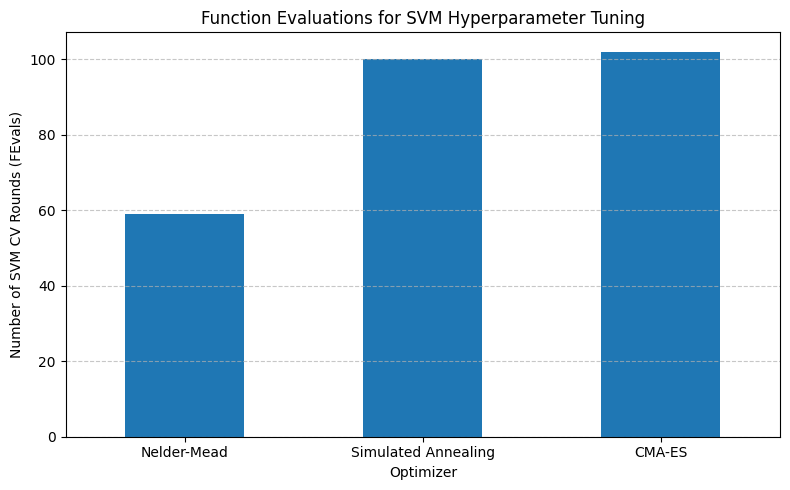

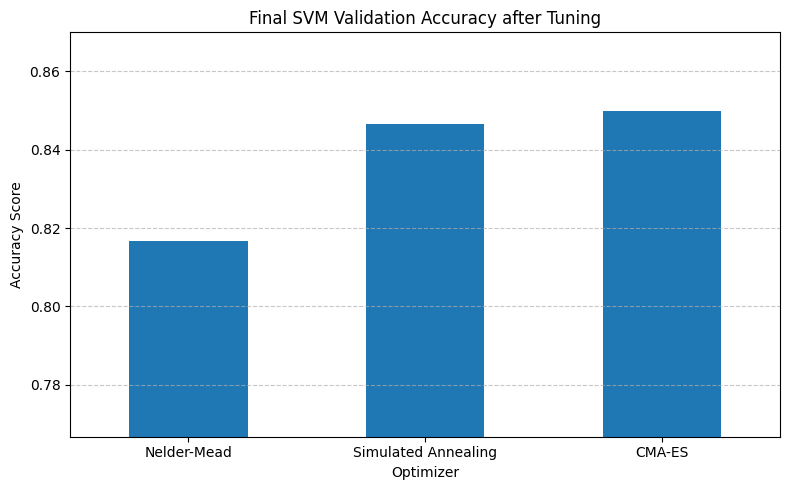

In [6]:
print("\n--- Task 2: Hyperparameter Tuning (SVM on MNIST) ---")

print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False, parser='auto')
X, y = mnist["data"], mnist["target"].astype(np.uint8)
print(f"MNIST data loaded: X shape={X.shape}, y shape={y.shape}")

print(f"Using a subset of {MNIST_SUBSET_SIZE} samples for tuning.")
X_subset, _, y_subset, _ = train_test_split(X, y, train_size=MNIST_SUBSET_SIZE, stratify=y, random_state=RANDOM_STATE)

X_train_svm, X_val_svm, y_train_svm, y_val_svm = train_test_split(
    X_subset, y_subset, test_size=0.3, stratify=y_subset, random_state=RANDOM_STATE)

print(f"Subset split: Train shape={X_train_svm.shape}, Validation shape={X_val_svm.shape}")

print("Scaling data...")
scaler = StandardScaler()
X_train_svm_scaled = scaler.fit_transform(X_train_svm)
X_val_svm_scaled = scaler.transform(X_val_svm)


svm_fevals_count = {'Nelder-Mead': 0, 'Simulated Annealing': 0, 'CMA-ES': 0}

def svm_objective(params_log, X_train, y_train, optimizer_name):
    if optimizer_name in svm_fevals_count:
         svm_fevals_count[optimizer_name] += 1
            
    eval_num = svm_fevals_count.get(optimizer_name, 0)

    try:
        log10_C, log10_gamma = params_log
        C = 10**log10_C
        gamma = 10**log10_gamma
        model = SVC(C=C, gamma=gamma, kernel='rbf', random_state=RANDOM_STATE, cache_size=500) # Added cache_size
        score = cross_val_score(model, X_train, y_train, cv=SVM_CV_FOLDS, scoring='accuracy', n_jobs=-1).mean()
        objective_value = 1.0 - score

        if eval_num > 0 and eval_num % 10 == 0:
           print(f"  {optimizer_name} Eval #{eval_num}: C={C:.3f}, gamma={gamma:.4f}, CV Acc={score:.4f}, Obj={objective_value:.4f}")

        if not np.isfinite(objective_value):
             objective_value = 1.0

        return objective_value

    except Exception as e:
        print(f"Error during SVM evaluation (params={params_log}): {e}")
        return 1.0


print("\n===== Applying Optimizers to SVM Tuning =====")
results_svm = {}
svm_bounds = SVM_BOUNDS_LOG

svm_opts = {'maxiter': MAX_ITER_SVM, 'maxfev': MAX_FEVALS_SVM}

start_point_svm = np.array([np.mean(b) for b in svm_bounds])

optimizer_name = "Nelder-Mead"
print(f"\nRunning {optimizer_name} for SVM tuning...")
svm_fevals_count[optimizer_name] = 0
t0 = time.time()
res_nm_svm = minimize(lambda p: svm_objective(p, X_train_svm_scaled, y_train_svm, optimizer_name), start_point_svm, method='Nelder-Mead', options=svm_opts)
t1 = time.time()
results_svm[optimizer_name] = {'res': res_nm_svm, 'time': t1-t0, 'fevals': svm_fevals_count[optimizer_name], 'best_params_log': res_nm_svm.x, 'min_objective': res_nm_svm.fun}
print(f"{optimizer_name} (SVM): Done in {t1-t0:.2f}s, FEvals={results_svm[optimizer_name]['fevals']}, Best Obj={res_nm_svm.fun:.4f}")


optimizer_name = "Simulated Annealing"
print(f"\nRunning {optimizer_name} for SVM tuning...")
svm_fevals_count[optimizer_name] = 0
t0 = time.time()
res_sa_svm = dual_annealing(lambda p: svm_objective(p, X_train_svm_scaled, y_train_svm, optimizer_name), bounds=svm_bounds, x0=start_point_svm, maxiter=svm_opts['maxiter'], maxfun=svm_opts['maxfev'], seed=RANDOM_STATE)
t1 = time.time()
results_svm[optimizer_name] = {'res': res_sa_svm, 'time': t1-t0, 'fevals': svm_fevals_count[optimizer_name], 'best_params_log': res_sa_svm.x, 'min_objective': res_sa_svm.fun}
print(f"{optimizer_name} (SVM): Done in {t1-t0:.2f}s, FEvals={results_svm[optimizer_name]['fevals']}, Best Obj={res_sa_svm.fun:.4f}")


optimizer_name = "CMA-ES"
print(f"\nRunning {optimizer_name} for SVM tuning...")
svm_fevals_count[optimizer_name] = 0
sigma0_svm = (svm_bounds[0][1] - svm_bounds[0][0]) / 4
cma_options_svm = {
    'bounds': [[b[0] for b in svm_bounds], [b[1] for b in svm_bounds]],
    'maxfevals': svm_opts['maxfev'],
    'verb_disp': 0, 'verb_log': 0,
    'seed': RANDOM_STATE
}
es_svm = cma.CMAEvolutionStrategy(start_point_svm, sigma0_svm, inopts=cma_options_svm)

t0 = time.time()
res_cma_svm = es_svm.optimize(lambda p: svm_objective(p, X_train_svm_scaled, y_train_svm, optimizer_name))
t1 = time.time()

results_svm[optimizer_name] = {'res': es_svm.result, 'time': t1-t0, 'fevals': svm_fevals_count[optimizer_name], 'best_params_log': es_svm.result.xbest, 'min_objective': es_svm.result.fbest}
print(f"{optimizer_name} (SVM): Done in {t1-t0:.2f}s, FEvals={results_svm[optimizer_name]['fevals']}, Best Obj={es_svm.result.fbest:.4f}")


print("\n===== SVM Tuning Performance Summary =====")
svm_summary_list = []
for opt, res_data in results_svm.items():
    logC, logG = res_data['best_params_log']
    best_C = 10**logC
    best_gamma = 10**logG
    print(f"  Testing final params for {opt}: C={best_C:.4f}, gamma={best_gamma:.4f}")
    final_svm = SVC(C=best_C, gamma=best_gamma, kernel='rbf', random_state=RANDOM_STATE)
    final_svm.fit(X_train_svm_scaled, y_train_svm)
    y_pred_val = final_svm.predict(X_val_svm_scaled)
    final_acc = accuracy_score(y_val_svm, y_pred_val)
    print(f"    Validation Accuracy: {final_acc:.4f}")

    svm_summary_list.append({
        'Optimizer': opt,
        'FEvals': res_data['fevals'],
        'Time (s)': res_data['time'],
        'Best Objective (1-CV_Acc)': res_data['min_objective'],
        'Final Validation Acc': final_acc,
        'Best log10(C)': logC,
        'Best log10(gamma)': logG
    })

df_svm_results = pd.DataFrame(svm_summary_list).set_index('Optimizer')
print("\nSVM Tuning Results:")
print(df_svm_results[['FEvals', 'Time (s)', 'Best Objective (1-CV_Acc)', 'Final Validation Acc']])


df_svm_results['FEvals'].plot(kind='bar', figsize=(8, 5))
plt.title('Function Evaluations for SVM Hyperparameter Tuning')
plt.ylabel('Number of SVM CV Rounds (FEvals)')
plt.xlabel('Optimizer')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_PATH, 'p2_svm_convergence.png'))
plt.show()

df_svm_results['Final Validation Acc'].plot(kind='bar', figsize=(8, 5))
plt.title('Final SVM Validation Accuracy after Tuning')
plt.ylabel('Accuracy Score')
plt.xlabel('Optimizer')
plt.xticks(rotation=0)
acc_min = df_svm_results['Final Validation Acc'].min()
acc_max = df_svm_results['Final Validation Acc'].max()
plt.ylim(bottom=max(0, acc_min - 0.05), top=min(1, acc_max + 0.02))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_PATH, 'p2_svm_accuracy.png'))
plt.show()


--- Task 3: Performance Analysis and Visualization ---
Creating SVM accuracy grid for visualization (this might take some time)...


Grid Search C:   0%|          | 0/10 [00:00<?, ?it/s]

Grid search completed after 100 SVM evaluations.


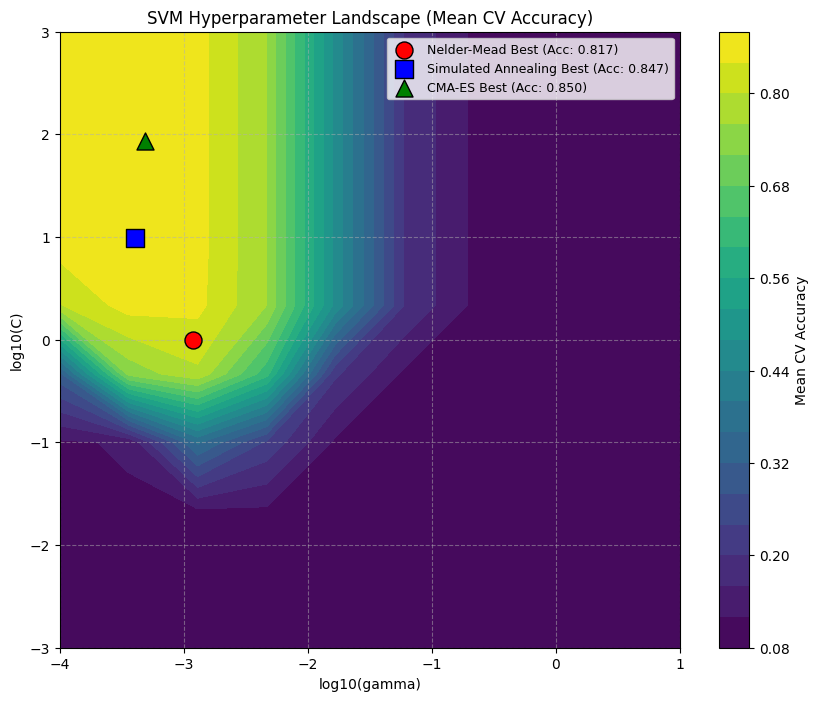


--- Problem 2 Finished ---


In [7]:
print("\n--- Task 3: Performance Analysis and Visualization ---")

log_C_range = np.linspace(SVM_BOUNDS_LOG[0][0], SVM_BOUNDS_LOG[0][1], 10)
log_gamma_range = np.linspace(SVM_BOUNDS_LOG[1][0], SVM_BOUNDS_LOG[1][1], 10)
accuracy_grid = np.zeros((len(log_C_range), len(log_gamma_range)))

print("Creating SVM accuracy grid for visualization (this might take some time)...")
grid_fevals = 0
for i, logC in enumerate(tqdm(log_C_range, desc="Grid Search C")):
    for j, logG in enumerate(log_gamma_range):
        obj_val = svm_objective([logC, logG], X_train_svm_scaled, y_train_svm, "GridSearch")
        accuracy_grid[i, j] = 1.0 - obj_val
        grid_fevals += 1

print(f"Grid search completed after {grid_fevals} SVM evaluations.")

plt.figure(figsize=(10, 8))
contour = plt.contourf(log_gamma_range, log_C_range, accuracy_grid, levels=20, cmap='viridis')
plt.colorbar(contour, label='Mean CV Accuracy')

markers_opt = {'Nelder-Mead': 'o', 'Simulated Annealing': 's', 'CMA-ES': '^'}
colors_opt = {'Nelder-Mead': 'red', 'Simulated Annealing': 'blue', 'CMA-ES': 'green'}

for opt_name, result in results_svm.items():
     best_params = result['best_params_log']
     plt.scatter(best_params[1], best_params[0], marker=markers_opt[opt_name], s=150, label=f'{opt_name} Best (Acc: {df_svm_results.loc[opt_name, "Final Validation Acc"]:.3f})', edgecolors='black', facecolors=colors_opt[opt_name], zorder=5)

plt.xlabel('log10(gamma)')
plt.ylabel('log10(C)')
plt.title('SVM Hyperparameter Landscape (Mean CV Accuracy)')
plt.legend(fontsize=9)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(os.path.join(PLOT_PATH, 'p2_svm_landscape.png'))
plt.show()

print("\n--- Problem 2 Finished ---")